In [17]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from IPython.display import display, Image as IPImage

In [2]:
def f(x: float, y: float) -> float:
    """
    Objective function to be minimized.

    Args:
    x (float): First parameter
    y (float): Second parameter

    Returns:
    float: The function value at (x, y)
    """
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)


In [6]:
class Individual:
    """
    Represents an individual in the population.

    Each individual has a set of genes (x and y values) and a fitness score.
    """

    def __init__(self, x: float, y: float):
        """
        Initialize an individual with given x and y values.
        """
        self.genes = np.array([x, y])
        self.fitness = None

    def calculate_fitness(self):
        """
        Calculate the fitness of the individual.

        Fitness is the negative of the objective function (as we want to maximize fitness).
        """
        self.fitness = -f(self.genes[0], self.genes[1])

    def mutate(self, mutation_rate: float):
        """
        Apply mutation to the individual's genes.

        Args:
        mutation_rate (float): Probability of mutation occurring
        """
        if np.random.rand() < mutation_rate:
            self.genes += np.random.normal(0, 0.1, 2)


In [9]:
class Population:
    """
    Represents a population of individuals.
    """

    def __init__(self, size: int, x_range: tuple[float, float], y_range: tuple[float, float]):
        """
        Initialize a population with random individuals.

        Args:
        size (int): Number of individuals in the population
        x_range (tuple[float, float]): Range for x values
        y_range (tuple[float, float]): Range for y values
        """
        self.individuals = [Individual(np.random.uniform(*x_range), np.random.uniform(*y_range)) for _ in range(size)]
        self.size = size

    def evaluate(self):
        """
        Evaluate the fitness of all individuals in the population.
        """
        for ind in self.individuals:
            ind.calculate_fitness()

    def sort(self):
        """
        Sort the population by fitness in descending order.
        """
        self.individuals.sort(key=lambda x: x.fitness, reverse=True)



In [15]:
def crossover(parent1: Individual, parent2: Individual) -> Individual:
    """
    Perform crossover between two parents to create a child.

    Args:
    parent1 (Individual): First parent
    parent2 (Individual): Second parent

    Returns:
    Individual: The child created from the parents
    """
    child_genes = (parent1.genes + parent2.genes) / 2
    return Individual(child_genes[0], child_genes[1])

def genetic_algorithm(pop_size: int, num_generations: int, num_replacements: int, mutation_rate: float, x_range: tuple[float, float], y_range: tuple[float, float]) -> tuple[Population, list[float]]:
    """
    Run the genetic algorithm optimization.

    Args:
    pop_size (int): Size of the population
    num_generations (int): Number of generations to run
    num_replacements (int): Number of individuals to replace in each generation
    mutation_rate (float): Probability of mutation for each individual
    x_range (tuple[float, float]): Range for x values
    y_range (tuple[float, float]): Range for y values

    Returns:
    tuple[Population, list[float]]: Final population and history of best fitness values
    """
    population = Population(pop_size, x_range, y_range)
    top_6_history = []

    for _ in range(num_generations):
        population.evaluate()
        population.sort()

        top_6 = [(ind.genes[0], ind.genes[1]) for ind in population.individuals[:6]]
        top_6_history.append(top_6)

        for i in range(num_replacements):
            parent1 = population.individuals[i]
            parent2 = population.individuals[-(i+1)]
            child = crossover(parent1, parent2)
            population.individuals[-(i+1)] = child

        for ind in population.individuals:
            ind.mutate(mutation_rate)

    return population, top_6_history


In [34]:
def create_contour_plot(x_range: tuple[float, float],
                        y_range: tuple[float, float],
                        ref_point: tuple[float, float],
                        top_6: list[tuple[float, float]],
                        iteration: int) -> Image.Image:

    """Create a contour plot with the reference point and top 6 individuals."""
    x = np.linspace(0, 5, 100)
    y = np.linspace(0, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=20, cmap='YlOrRd')
    plt.colorbar(label='Objective Function Value')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.plot(ref_point[0], ref_point[1], 'kX', markersize=10, label='Optimum')
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i, (x, y) in enumerate(top_6):
        plt.plot(x, y, f'{colors[i]}o', markersize=8, label=f'Individual {i+1}')

    # Add the iteration number in the title
    plt.title(f"Iteration {iteration}")

    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    return img

In [35]:
def create_animation(top_6_history: list[list[tuple[float, float]]], x_range: tuple[float, float], y_range: tuple[float, float], ref_point: tuple[float, float]):
    """Create an animated GIF of the optimization process and return it as bytes."""
    frames = []
    for iteration, top_6 in enumerate(top_6_history, start=1):
        img = create_contour_plot(x_range, y_range, ref_point, top_6, iteration)
        frames.append(img)

    # Save the animation to a bytes buffer
    buf = io.BytesIO()
    frames[0].save(buf, format='gif', save_all=True, append_images=frames[1:], duration=200, loop=0)
    buf.seek(0)

    return buf.getvalue()

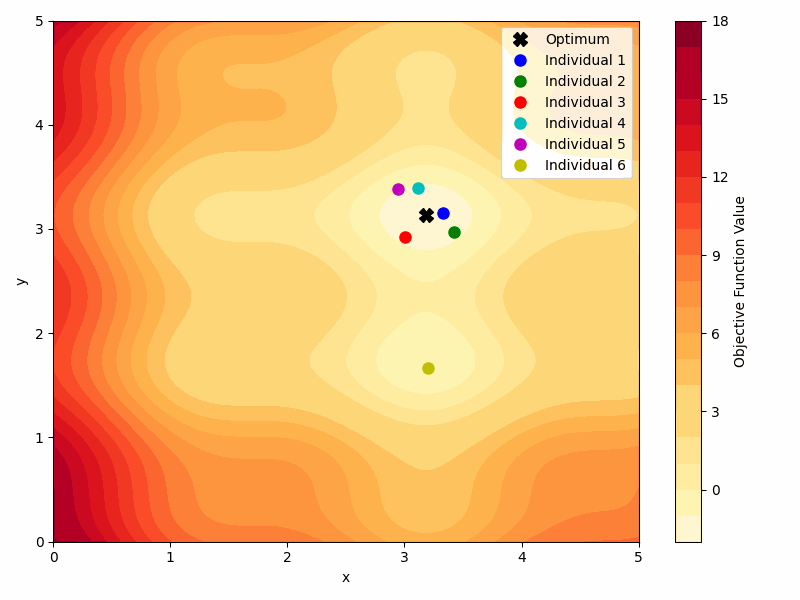

Reference solution: x = 3.18516, y = 3.12980
Reference fitness: -1.808350
Best solution found: x = 3.18444, y = 3.13811
Best fitness found: -1.807739


In [36]:
"""Main call to run the genetic algorithm and create the animation."""
pop_size = 100
num_generations = 50
num_replacements = 20
mutation_rate = 0.1
x_range = (1.0, 3.5)
y_range = (1.5, 5.0)

ref_x = 3.18516
ref_y = 3.1298
ref_value = -1.80835

final_population, top_6_history = genetic_algorithm(pop_size, num_generations, num_replacements, mutation_rate, x_range, y_range)

# Create and display the animation
animation_data = create_animation(top_6_history, x_range, y_range, (ref_x, ref_y))
display(IPImage(animation_data, format='gif'))

print(f"Reference solution: x = {ref_x:.5f}, y = {ref_y:.5f}")
print(f"Reference fitness: {ref_value:.6f}")

best_individual = final_population.individuals[0]
print(f"Best solution found: x = {best_individual.genes[0]:.5f}, y = {best_individual.genes[1]:.5f}")
print(f"Best fitness found: {-best_individual.fitness:.6f}")